# Discrete structural parameter
Obtaining features and applying adaptive kernel density estimation. For visualization purposes, here we set the number of features $N_f=2$ for all cases.

In [41]:
import numpy as np
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [42]:
# Load traveltime data and place it an array m by n, where m is the number of 
# simulations and n is the number of traveltime data.
# The m=150 traveltime simulations are obtained from forward geophysical model applied to:
# 1st 50 --> multiple-point geostatistics simulations with channels.
# 2nd 50 --> multiple-point geostatistics simulations with overlapping ellipses.
# 3rd 50 --> truncated sequential gaussian simulations with anisotropic variogram.
ttdata = np.load('ttdata_disc.npy')
n = np.size(ttdata, axis=1)

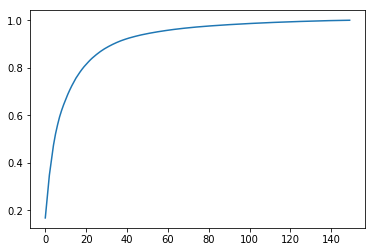

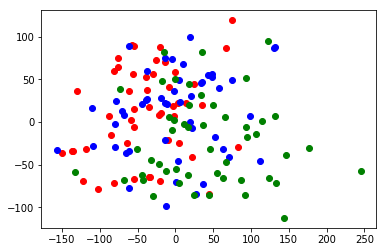

In [43]:
# PCA
dim = 2
mypca = PCA(n_components=dim)
lowdim = mypca.fit_transform(ttdata)
pcafit = PCA().fit(ttdata)
plt.plot(np.cumsum(pcafit.explained_variance_ratio_))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lowdim[0:49,0], lowdim[0:49,1], 'ro')
ax.plot(lowdim[50:99,0],lowdim[50:99,1],'bo')
ax.plot(lowdim[100:149,0],lowdim[100:149,1],'go')

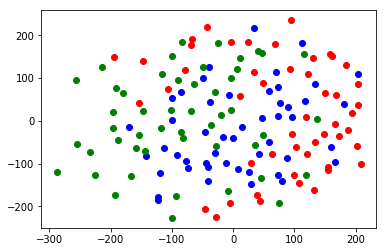

In [44]:
# MDS
dim=2
mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
lowdim = mymds.fit_transform(ttdata)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lowdim[0:49,0], lowdim[0:49,1], 'ro')
ax.plot(lowdim[50:99,0],lowdim[50:99,1],'bo')
ax.plot(lowdim[100:149,0],lowdim[100:149,1],'go')

In [45]:
# Compute histograms of traveltime data
nbins = 15
tthist = np.zeros([150,nbins])
rang = (np.min(ttdata), np.max(ttdata))
for i in range(len(ttdata)):
    tthist[i,:], _ = np.histogram(ttdata[i,:], bins=nbins, range=rang, density=True)

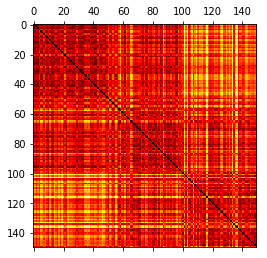

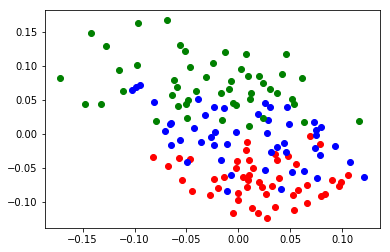

In [46]:
# Compute JS distance between histograms
from scipy.spatial.distance import pdist, squareform
from JSD import JSD
dJS = pdist(tthist, JSD)
dJS = np.sqrt(dJS)
# plot distance matrix
plt.matshow(squareform(dJS), cmap='hot')
# then apply MDS to Jensen-Shannon distance
dim=2
mymds = manifold.MDS(n_components=dim, random_state=8155, n_init=20, dissimilarity='precomputed')
lowdim = mymds.fit_transform(squareform(dJS))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lowdim[0:49,0], lowdim[0:49,1], 'ro')
ax.plot(lowdim[50:99,0],lowdim[50:99,1],'bo')
ax.plot(lowdim[100:149,0],lowdim[100:149,1],'go')

In [47]:
# Load (inverted) velocity matrix and place it an array m by n, where m is the number of 
# simulations and n is the number of velocity pixels.
veldata = np.load('veldata_disc.npy')
n = np.size(ttdata, axis=1)
# Build arrays (images) of the inverted velocities.
velimag = np.zeros((49,24,150))
for i in range(150):
    velimag[:,:,i] = veldata[i,:].reshape(49,24)

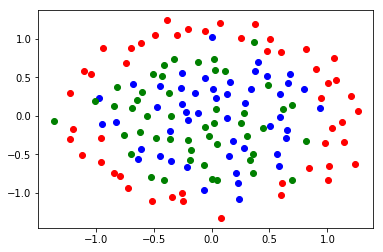

In [48]:
# MDS for inverted velocity.
dim=2
mymds = manifold.MDS(n_components=dim, random_state=5894, n_init=20)
lowdim = mymds.fit_transform(veldata)
# 2D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lowdim[0:49,0], lowdim[0:49,1], 'ro')
ax.plot(lowdim[50:99,0],lowdim[50:99,1],'bo')
ax.plot(lowdim[100:149,0],lowdim[100:149,1],'go')

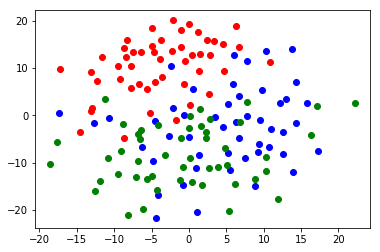

In [49]:
# MDS for connectivity indicator.
# Compute Euler characteristic curve
import euler_curve
nthreshold = 100
eulchar = euler_curve.euler_curve(velimag, nthreshold)
# MDS with Euler characteristic curve as a proxy
dim = 2
mymds = manifold.MDS(n_components=dim, random_state=2358, n_init=20)
lowdim = mymds.fit_transform(eulchar)
# 2D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lowdim[0:49,0], lowdim[0:49,1], 'ro')
ax.plot(lowdim[50:99,0],lowdim[50:99,1],'bo')
ax.plot(lowdim[100:149,0],lowdim[100:149,1],'go')

In [50]:
# Compute classification matrix with KDE, only for last cell ran. Check that "lowdim" is the method you want to test.

# Load density function for estimation with adaptive kernel smoothing 
from adap_ks import adap_ks
from adap_ks_out import adap_ks_out
# Compute density taking one observation at a time, for the three scenarios (i.e. density
# at the observation point computed considering only points in one scenario at a time)
K = 5
obs = lowdim[:,:dim]
prior = np.array([1/3, 1/3, 1/3])
dens1 = np.zeros(len(obs))
dens2 = np.zeros(len(obs))
dens3 = np.zeros(len(obs))
dens1[50:] = adap_ks(lowdim[:50,:], dim, K, obs[50:])
dens2[:50] = adap_ks(lowdim[50:100,:], dim, K, obs[:50])
dens2[100:] = adap_ks(lowdim[50:100,:], dim, K, obs[100:])
dens3[:100] = adap_ks(lowdim[100:150,:], dim, K, obs[:100])
nsims = 50
for i in range(50):
    #print(i)
    dens1[i] = adap_ks_out(lowdim[:50], dim, K, i, nsims)
    dens2[50+i] = adap_ks_out(lowdim[50:100], dim, K, i, nsims)
    dens3[100+i] = adap_ks_out(lowdim[100:], dim, K, i, nsims)
   
dens = np.column_stack([dens1, dens2, dens3])
pscen = np.zeros(dens.shape)
classp = np.zeros(dens.shape)
for i in range(len(dens)):
   pscen[i] = (prior*dens[i,:])/np.dot(prior,dens[i,:])
   classp[i] = 1*(pscen[i] == np.max(pscen[i]))
   
# Build classification matrix (confusion matrix) and mean updated probability matrix.
nscen = 3
pscen_eff = np.zeros([nscen, nscen])
classp_eff = np.zeros([nscen, nscen])
for i in range(nscen):
    classp_eff[i] = sum(classp[i*50:(i+1)*50])
    pscen_eff[i] = np.mean(pscen[i*50:(i+1)*50], axis=0)

In [51]:
# Print classification matrix (correctly classified scenarios are along the diagonal) 
# and mean updated probability matrix.
print(classp_eff)
print('correctly classified scenarios:',np.sum(np.diag(classp_eff)))
print(pscen_eff)
print('mean updated probability:',np.mean(np.diag(pscen_eff)))

[[41.  6.  3.]
 [ 8. 21. 21.]
 [ 2. 13. 35.]]
correctly classified scenarios: 97.0
[[0.76601632 0.16017573 0.07380795]
 [0.14283982 0.45638334 0.40077684]
 [0.06976842 0.4083659  0.52186567]]
mean updated probability: 0.5814217780724164
